# Prize-Collecting Steiner Tree (PCSTP)

## Libs Importing

In [1]:
import sys
import os
import time
import networkx as nx

sys.path.insert(1, os.path.realpath(os.path.pardir))

In [2]:
from pcstp.instances.generator import generate_random_steiner
from pcstp.utils.draw import draw_steiner_graph

## Experiments

In [3]:
G, (nodes, edges, position_matrix, edges_cost, terminals, prizes) = generate_random_steiner(
    num_nodes=20,
    num_edges=24,
    max_node_degree=10,
    min_prize=0,
    max_prize=100,
    num_terminals=5,
    min_edge_cost=0,
    max_edge_cost=10,
    cost_as_length=False,
    max_iter=100,
    seed=1
)

terminals:  (5,)
prizes:  (5,)


In [4]:
start_time = time.time()

nx_steiner_tree = nx.algorithms.approximation.steinertree.steiner_tree(
    G,
    terminals,
    weight='cost'
)

networkx_duration = time.time() - start_time

In [5]:
from pcstp.steinertree import SteinerTreeProblem
from pcstp.instances.reader import SteinlibReader, DatReader

In [6]:
stp_reader = SteinlibReader()
stp = stp_reader.parser(filename='../data/instances/C01-A.stp')

# Shortest Path - Greedy Heuristic

In [7]:
from pcstp.solver.greedy_h1 import GreedyH1

In [8]:
solver = GreedyH1(G, terminals)

In [9]:
steiner_tree, steiner_cost = solver.solve()
print(f'Steiner Cost: {steiner_cost}')


Finding all paths between 18 and 16...
Path between 18 and 16 ([18, 1, 3, 17, 16]) - cost (55)
Finding all paths between 18 and 1...
Path between 18 and 1 ([18, 1]) - cost (107)
Finding all paths between 18 and 12...
Path between 18 and 12 ([18, 1, 3, 17, 16, 13, 9, 12]) - cost (37)
Finding all paths between 18 and 17...
Path between 18 and 17 ([18, 1, 3, 10, 9, 13, 16, 17]) - cost (59)
Finding all paths between 16 and 1...
Path between 16 and 1 ([16, 17, 3, 1]) - cost (135)
Finding all paths between 16 and 12...
Path between 16 and 12 ([16, 17, 3, 10, 9, 12]) - cost (116)
Finding all paths between 16 and 17...
Path between 16 and 17 ([16, 17]) - cost (126)
Finding all paths between 1 and 12...
Path between 1 and 12 ([1, 3, 17, 16, 13, 9, 12]) - cost (117)
Finding all paths between 1 and 17...
Path between 1 and 17 ([1, 3, 10, 9, 13, 16, 17]) - cost (139)
Finding all paths between 12 and 17...
Path between 12 and 17 ([12, 9, 13, 16, 17]) - cost (108)
Runtime of the program is 41.031599

## Solution obtained with NetworkX Steiner Tree Approximation Algorithm

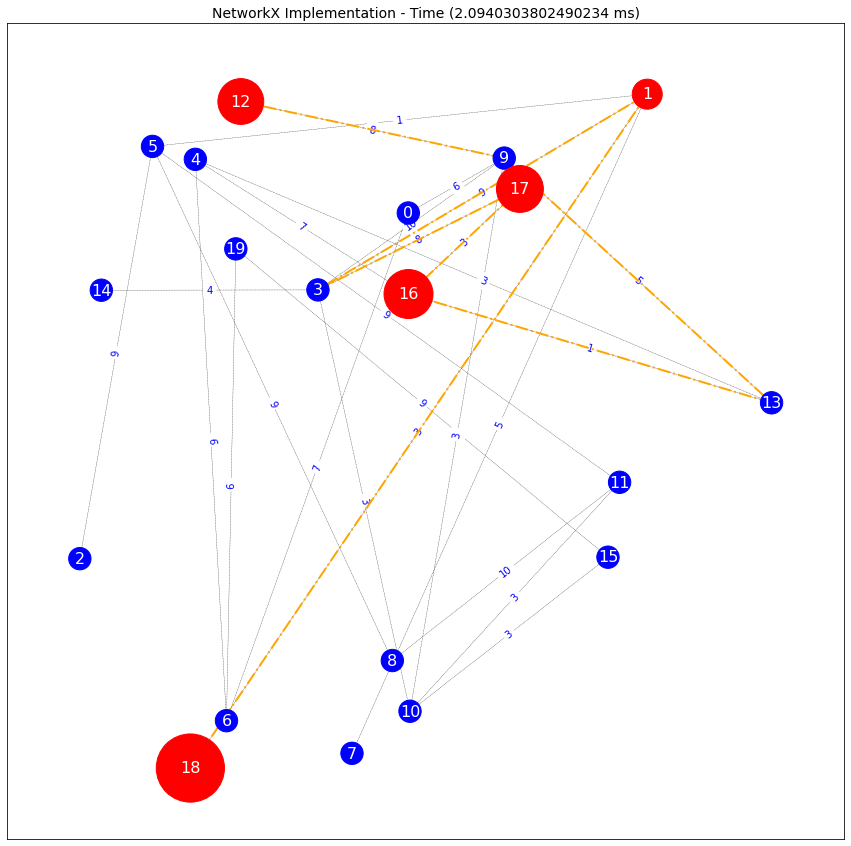

In [10]:
draw_steiner_graph(
    G,
    steiner_graph=nx_steiner_tree,
    plot_title=f'NetworkX Implementation - Time ({networkx_duration * 1000} ms)',
    node_label='name'
)


## Solution obtained with Greedy Heuristic Algorithm

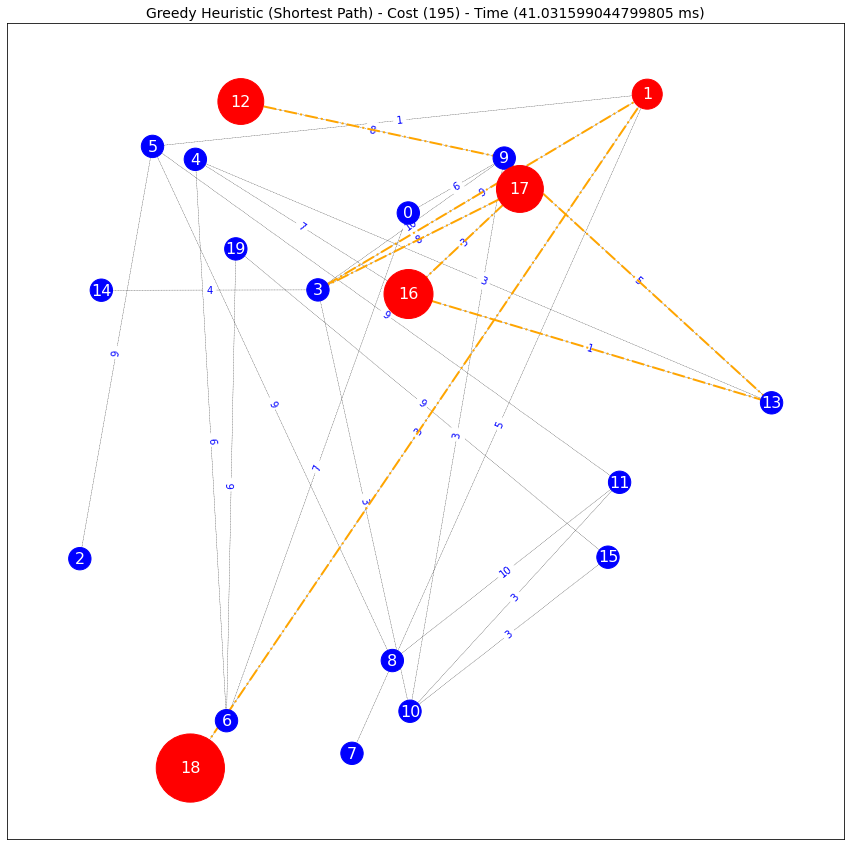

In [11]:
draw_steiner_graph(
    G,
    steiner_graph=steiner_tree,
    plot_title=f'Greedy Heuristic (Shortest Path) - Cost ({steiner_cost}) - Time ({solver._duration * 1000} ms)',
    node_label='name'
)
